In [1]:
import pandas as pd
import numpy as np
import os
import json
import glob
import re
from matplotlib import pyplot as plt
from monty.serialization import loadfn
from sklearn.metrics import r2_score 
from scipy import stats

## Comparing Old to New

In [2]:
old_df = pd.read_csv("OldDataFastCharge.csv")
new_df = pd.read_csv("LFPBatteries.csv")

In [3]:
old_df.shape, new_df.shape

((139, 54), (30, 25))

In [46]:
columns_rename = {}
for col in list(old_df.columns):
    if "X." in col:
        columns_rename[col] = col.replace("X.", "")
old_df = old_df.rename(columns=columns_rename)
old_df.columns

Index(['level_0', '@module_x', '@class_x', 'name_x', '@version_x',
       'discharge_capacity_cycle_2', 'max_discharge_capacity_difference',
       'discharge_capacity_cycle_100',
       'integrated_time_temperature_cycles_1:100', 'charge_time_cycles_1:5',
       'abs_min_discharge_capacity_difference_cycles_2:100',
       'abs_mean_discharge_capacity_difference_cycles_2:100',
       'abs_variance_discharge_capacity_difference_cycles_2:100',
       'abs_skew_discharge_capacity_difference_cycles_2:100',
       'abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'abs_first_discharge_capacity_difference_cycles_2:100',
       'max_temperature_cycles_1:100', 'min_temperature_cycles_1:100',
       'slope_discharge_capacity_cycle_number_2:100',
       'intercept_discharge_capacity_cycle_number_2:100',
       'slope_discharge_capacity_cycle_number_91:100',
       'intercept_discharge_capacity_cycle_number_91:100',
       'min_internal_resistance_cycles_2:100', 'internal_resistanc

In [47]:
new_df.columns

Index(['abs_first_discharge_capacity_difference_cycles_2:100',
       'abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'abs_mean_discharge_capacity_difference_cycles_2:100',
       'abs_min_discharge_capacity_difference_cycles_2:100',
       'abs_skew_discharge_capacity_difference_cycles_2:100',
       'abs_variance_discharge_capacity_difference_cycles_2:100',
       'charge_time_cycles_1:5', 'discharge_capacity_cycle_100',
       'discharge_capacity_cycle_2',
       'integrated_time_temperature_cycles_1:100',
       'intercept_discharge_capacity_cycle_number_2:100',
       'intercept_discharge_capacity_cycle_number_91:100',
       'max_discharge_capacity_difference', 'max_temperature_cycles_1:100',
       'min_temperature_cycles_1:100', 'nominal_capacity_by_median',
       'slope_discharge_capacity_cycle_number_2:100',
       'slope_discharge_capacity_cycle_number_91:100', 'capacity_0.8',
       'capacity_0.83', 'capacity_0.86', 'capacity_0.89', 'capacity_0.92',
     

Check correlations of X_variables

In [48]:
old_df.corr()[old_df.corr().abs() >= .5].iloc[:18, :18]

,level_0,discharge_capacity_cycle_2,max_discharge_capacity_difference,discharge_capacity_cycle_100,integrated_time_temperature_cycles_1:100,charge_time_cycles_1:5,abs_min_discharge_capacity_difference_cycles_2:100,abs_mean_discharge_capacity_difference_cycles_2:100,abs_variance_discharge_capacity_difference_cycles_2:100,abs_skew_discharge_capacity_difference_cycles_2:100,abs_kurtosis_discharge_capacity_difference_cycles_2:100,abs_first_discharge_capacity_difference_cycles_2:100,max_temperature_cycles_1:100,min_temperature_cycles_1:100,slope_discharge_capacity_cycle_number_2:100,intercept_discharge_capacity_cycle_number_2:100,slope_discharge_capacity_cycle_number_91:100,intercept_discharge_capacity_cycle_number_91:100
level_0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discharge_capacity_cycle_2,NaN,1.000000,NaN,0.855589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986637,NaN,0.950076
max_discharge_capacity_difference,NaN,NaN,1.000000,NaN,0.729663,NaN,0.550139,0.504383,0.546763,NaN,NaN,0.559174,NaN,NaN,NaN,NaN,NaN,NaN
discharge_capacity_cycle_100,NaN,0.855589,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.698538,0.836700,0.596959,0.753078
integrated_time_temperature_cycles_1:100,NaN,NaN,0.729663,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charge_time_cycles_1:5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abs_min_discharge_capacity_difference_cycles_2:100,NaN,NaN,0.550139,NaN,NaN,NaN,1.000000,0.946379,0.980687,NaN,NaN,0.974062,NaN,NaN,NaN,NaN,-0.518965,NaN
abs_mean_discharge_capacity_difference_cycles_2:100,NaN,NaN,0.504383,NaN,NaN,NaN,0.946379,1.000000,0.935607,NaN,0.653892,0.931057,NaN,NaN,NaN,NaN,NaN,NaN
abs_variance_discharge_capacity_difference_cycles_2:100,NaN,NaN,0.546763,NaN,NaN,NaN,0.980687,0.935607,1.000000,NaN,NaN,0.968069,NaN,NaN,NaN,NaN,-0.523851,NaN
abs_skew_discharge_capacity_difference_cycles_2:100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
old_pairs = []
for pair in old_df.corr()[old_df.corr().abs() >= .5].iloc[:18, :18].stack().index.values:
    if pair[0] != pair[1]:
        if (pair[1], pair[0]) not in old_pairs:
            old_pairs.append(pair)

In [12]:
new_df.corr()[new_df.corr().abs() >= .5].iloc[:18, :18]

,abs_first_discharge_capacity_difference_cycles_2:100,abs_kurtosis_discharge_capacity_difference_cycles_2:100,abs_mean_discharge_capacity_difference_cycles_2:100,abs_min_discharge_capacity_difference_cycles_2:100,abs_skew_discharge_capacity_difference_cycles_2:100,abs_variance_discharge_capacity_difference_cycles_2:100,charge_time_cycles_1:5,discharge_capacity_cycle_100,discharge_capacity_cycle_2,integrated_time_temperature_cycles_1:100,intercept_discharge_capacity_cycle_number_2:100,intercept_discharge_capacity_cycle_number_91:100,max_discharge_capacity_difference,max_temperature_cycles_1:100,min_temperature_cycles_1:100,nominal_capacity_by_median,slope_discharge_capacity_cycle_number_2:100,slope_discharge_capacity_cycle_number_91:100
abs_first_discharge_capacity_difference_cycles_2:100,1.000000,-0.857846,0.806162,NaN,-0.573099,0.795595,0.828018,NaN,0.574807,NaN,NaN,NaN,NaN,0.815320,0.879548,NaN,-0.677286,NaN
abs_kurtosis_discharge_capacity_difference_cycles_2:100,-0.857846,1.000000,-0.885222,-0.572634,0.815180,-0.896389,-0.735469,NaN,-0.741110,NaN,-0.620281,NaN,-0.514772,-0.819216,-0.859432,-0.553653,0.798750,NaN
abs_mean_discharge_capacity_difference_cycles_2:100,0.806162,-0.885222,1.000000,0.698460,-0.526459,0.909149,0.567258,NaN,NaN,NaN,NaN,NaN,NaN,0.666889,0.704615,NaN,NaN,NaN
abs_min_discharge_capacity_difference_cycles_2:100,NaN,-0.572634,0.698460,1.000000,NaN,0.884176,NaN,0.820163,NaN,0.504514,0.831899,0.822071,0.898777,NaN,NaN,0.823042,0.681470,NaN
abs_skew_discharge_capacity_difference_cycles_2:100,-0.573099,0.815180,-0.526459,NaN,1.000000,-0.566956,NaN,NaN,-0.685438,NaN,-0.589591,NaN,NaN,-0.539233,-0.505910,-0.537571,0.658778,NaN
abs_variance_discharge_capacity_difference_cycles_2:100,0.795595,-0.896389,0.909149,0.884176,-0.566956,1.000000,NaN,0.672832,NaN,0.607292,0.682783,0.677121,0.722830,0.590146,0.578910,0.676527,0.568224,-0.534902
charge_time_cycles_1:5,0.828018,-0.735469,0.567258,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.517941,0.632446,NaN,NaN,NaN
discharge_capacity_cycle_100,NaN,NaN,NaN,0.820163,NaN,0.672832,NaN,1.000000,NaN,0.519324,0.999503,0.999836,0.969387,NaN,NaN,0.999931,0.964563,NaN
discharge_capacity_cycle_2,0.574807,-0.741110,NaN,NaN,-0.685438,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.520199,NaN
integrated_time_temperature_cycles_1:100,NaN,NaN,NaN,0.504514,NaN,0.607292,NaN,0.519324,NaN,1.000000,0.528616,0.521968,0.514611,0.604000,0.650971,0.523061,NaN,NaN


In [13]:
new_pairs = []
for pair in new_df.corr()[new_df.corr().abs() >= .5].iloc[:18, :18].stack().index.values:
    if pair[0] != pair[1]:
        if (pair[1], pair[0]) not in new_pairs:
            new_pairs.append(pair)

In [14]:
len(old_pairs), len(new_pairs)

(27, 79)

Very different correlations

In [15]:
old_df.corr().iloc[:18, 18]

abs_first_discharge_capacity_difference_cycles_2:100      -0.810575
abs_kurtosis_discharge_capacity_difference_cycles_2:100   -0.389637
abs_mean_discharge_capacity_difference_cycles_2:100       -0.819035
abs_min_discharge_capacity_difference_cycles_2:100        -0.829050
abs_skew_discharge_capacity_difference_cycles_2:100        0.367007
abs_variance_discharge_capacity_difference_cycles_2:100   -0.804505
charge_time_cycles_1:5                                     0.307029
discharge_capacity_cycle_100                               0.145955
discharge_capacity_cycle_2                                 0.059937
integrated_time_temperature_cycles_1:100                  -0.434728
intercept_discharge_capacity_cycle_number_2:100           -0.024254
intercept_discharge_capacity_cycle_number_91:100          -0.087665
max_discharge_capacity_difference                         -0.607487
max_temperature_cycles_1:100                              -0.116969
min_temperature_cycles_1:100                    

In [16]:
new_df.corr().iloc[:18, 18]

abs_first_discharge_capacity_difference_cycles_2:100      -0.100305
abs_kurtosis_discharge_capacity_difference_cycles_2:100    0.000864
abs_mean_discharge_capacity_difference_cycles_2:100       -0.185450
abs_min_discharge_capacity_difference_cycles_2:100        -0.547479
abs_skew_discharge_capacity_difference_cycles_2:100        0.021071
abs_variance_discharge_capacity_difference_cycles_2:100   -0.429684
charge_time_cycles_1:5                                     0.169681
discharge_capacity_cycle_100                              -0.882567
discharge_capacity_cycle_2                                 0.447140
integrated_time_temperature_cycles_1:100                  -0.474322
intercept_discharge_capacity_cycle_number_2:100           -0.883065
intercept_discharge_capacity_cycle_number_91:100          -0.882244
max_discharge_capacity_difference                         -0.801524
max_temperature_cycles_1:100                              -0.218862
min_temperature_cycles_1:100                    

### Looking at the inital difference

#### Variance Model

The correlation between the cycle life and the absolute variance of the discharge capacity difference between cycles 2 and 100 is a lot stronger in the old data versus the new LFP data. Old data: -0.805. BatteryArchive data: -0.430


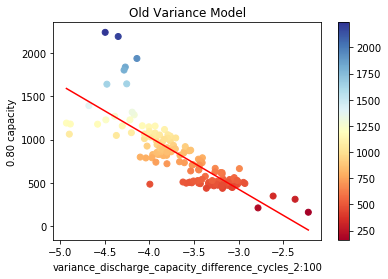

In [17]:
y = old_df["capacity_0.8"]
x = old_df["abs_variance_discharge_capacity_difference_cycles_2:100"]
y2 = y[x.index]
#fig.add_subplot(len(xvars), 1, i + 1)
plt.xlabel("variance_discharge_capacity_difference_cycles_2:100")
plt.ylabel('0.80 capacity')
plt.scatter(x, y2, c=y2, cmap="RdYlBu")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
plt.colorbar()
plt.title("Old Variance Model")
plt.show()

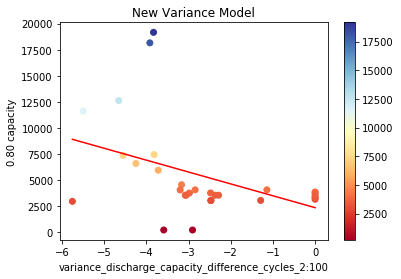

In [18]:
y = new_df["capacity_0.8"]
x = new_df["abs_variance_discharge_capacity_difference_cycles_2:100"]
y2 = y[x.index]
#fig.add_subplot(len(xvars), 1, i + 1)
plt.xlabel("variance_discharge_capacity_difference_cycles_2:100")
plt.ylabel('0.80 capacity')
plt.scatter(x, y2, c=y2, cmap="RdYlBu")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
plt.colorbar()
plt.title("New Variance Model")
plt.show()

#### Discharge Model

From the plots below, we see a few stark differences.
First, 

In [19]:
discharge_model_features = ['abs_min_discharge_capacity_difference_cycles_2:100',
                            #'abs_variance_discharge_capacity_difference_cycles_2:100',
                            'abs_skew_discharge_capacity_difference_cycles_2:100',
                            'abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'discharge_capacity_cycle_2',
                            'max_discharge_capacity_difference'
                            ]

abs_min_discharge_capacity_difference_cycles_2:100
Old Data Correlation:  -0.8290501202331472


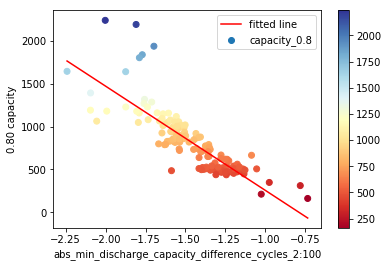

c:\users\mattm\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


New Data Correlation:  -0.5474785260307109


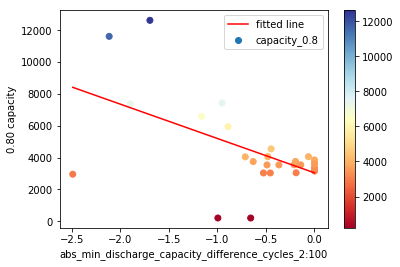

abs_skew_discharge_capacity_difference_cycles_2:100
Old Data Correlation:  0.36700686702247914


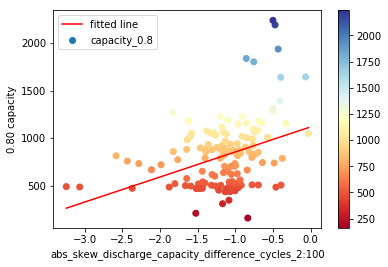

New Data Correlation:  0.021071177194162276


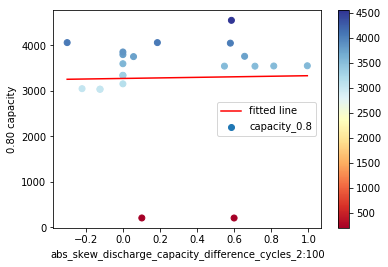

abs_kurtosis_discharge_capacity_difference_cycles_2:100
Old Data Correlation:  -0.3896371412383919


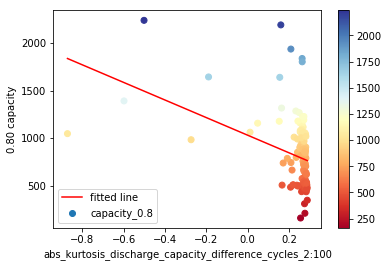

New Data Correlation:  0.0008637207942007164


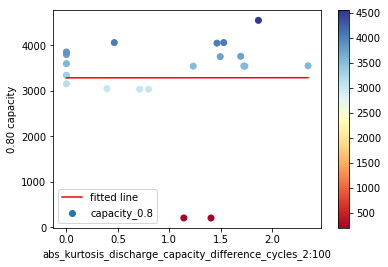

discharge_capacity_cycle_2
Old Data Correlation:  0.05993700500142466


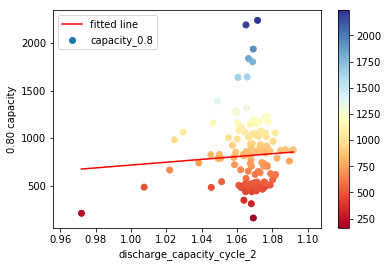

New Data Correlation:  0.44713987196957045


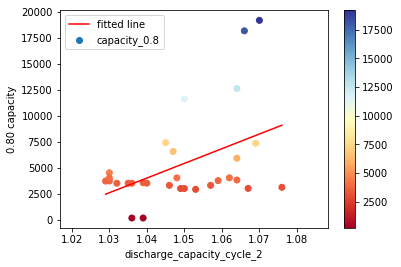

max_discharge_capacity_difference
Old Data Correlation:  -0.6074866859456474


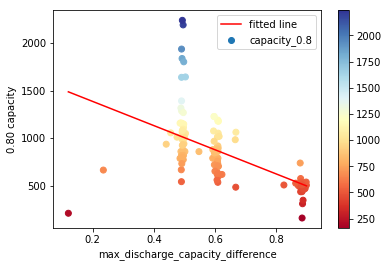

New Data Correlation:  -0.8015235061168772


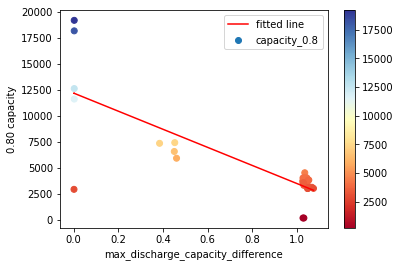

In [20]:
y = old_df["capacity_0.8"]
old_corrs = old_df.corr().iloc[:18, 18][discharge_model_features]
new_corrs = new_df.corr().iloc[:18, 18][discharge_model_features]
fig = plt.Figure(figsize=(6,50))
for i in range(len(discharge_model_features)):
    y = old_df["capacity_0.8"]
    print(discharge_model_features[i])
    fig.add_subplot(len(discharge_model_features), 1, i+1)
    x = old_df[discharge_model_features[i]].replace([-np.inf, np.inf], np.nan).dropna()
    y2 = y[x.index]
    plt.xlabel(discharge_model_features[i])
    plt.ylabel('0.80 capacity')
    plt.scatter(x, y2, c=y2, cmap="RdYlBu")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
    plt.colorbar()
    plt.legend()
    print("Old Data Correlation: ", old_corrs[i])
    plt.show()
    
    y = new_df["capacity_0.8"]
    fig.add_subplot(len(discharge_model_features), 1, i+1)
    x = new_df[discharge_model_features[i]].replace([-np.inf, np.inf], np.nan).dropna()
    y2 = y[x.index]
    plt.xlabel(discharge_model_features[i])
    plt.ylabel('0.80 capacity')
    plt.scatter(x, y2, c=y2, cmap="RdYlBu")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
    plt.colorbar()
    plt.legend()
    print("New Data Correlation: ", new_corrs[i])
    plt.show()

In [21]:
old_corrs

abs_min_discharge_capacity_difference_cycles_2:100        -0.829050
abs_skew_discharge_capacity_difference_cycles_2:100        0.367007
abs_kurtosis_discharge_capacity_difference_cycles_2:100   -0.389637
discharge_capacity_cycle_2                                 0.059937
max_discharge_capacity_difference                         -0.607487
Name: capacity_0.8, dtype: float64

In [22]:
new_corrs

abs_min_discharge_capacity_difference_cycles_2:100        -0.547479
abs_skew_discharge_capacity_difference_cycles_2:100        0.021071
abs_kurtosis_discharge_capacity_difference_cycles_2:100    0.000864
discharge_capacity_cycle_2                                 0.447140
max_discharge_capacity_difference                         -0.801524
Name: capacity_0.8, dtype: float64

#### Full Model

Plot remaining variables used in the full model

In [24]:
full_model_features = [#'abs_min_discharge_capacity_difference_cycles_2:100',
                       #'abs_variance_discharge_capacity_difference_cycles_2:100',
                       'slope_discharge_capacity_cycle_number_2:100',
                       'intercept_discharge_capacity_cycle_number_2:100',
                       #'discharge_capacity_cycle_2',
                       'charge_time_cycles_1:5',
                       'integrated_time_temperature_cycles_1:100']
                       #'min_internal_resistance_cycles_2:100',
                       #'internal_resistance_difference_cycles_2:100']

slope_discharge_capacity_cycle_number_2:100
Old Data Correlation:  0.2740760701807934


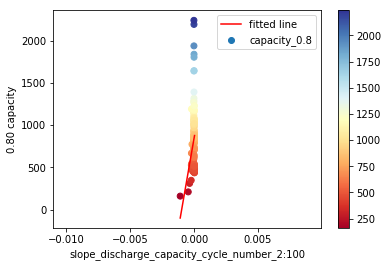

New Data Correlation:  -0.8459484490468216


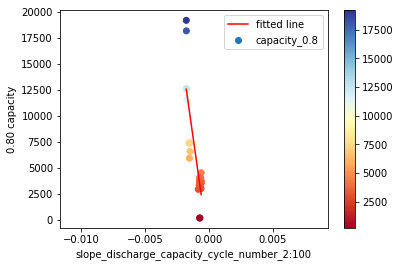

intercept_discharge_capacity_cycle_number_2:100
Old Data Correlation:  -0.024254256705455585


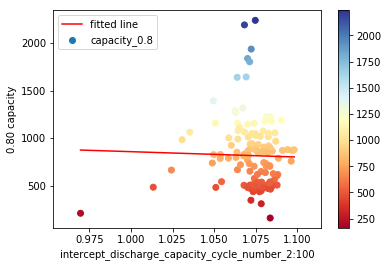

New Data Correlation:  -0.8830649616158572


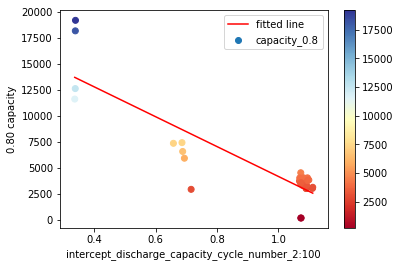

charge_time_cycles_1:5
Old Data Correlation:  0.30702876917067595


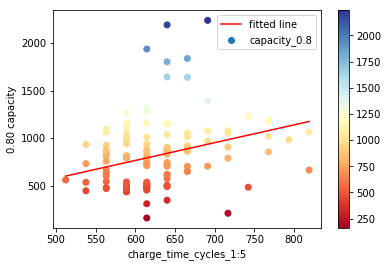

New Data Correlation:  0.16968136292810676


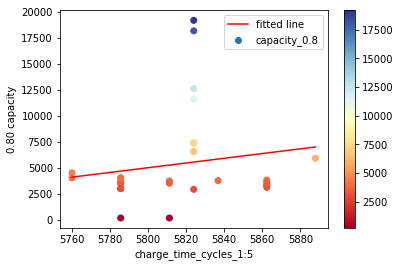

integrated_time_temperature_cycles_1:100
Old Data Correlation:  -0.4347280316642188


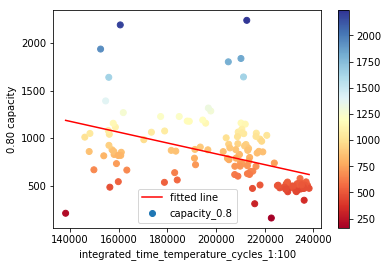

New Data Correlation:  -0.47432208878099735


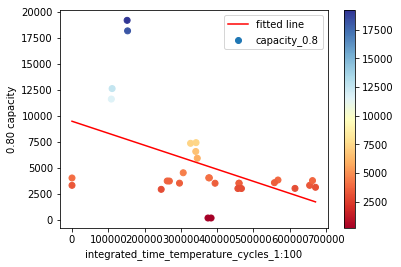

In [25]:
y = old_df["capacity_0.8"]
old_corrs = old_df.corr().iloc[:18, 18][full_model_features]
new_corrs = new_df.corr().iloc[:18, 18][full_model_features]
fig = plt.Figure(figsize=(6,50))
for i in range(len(full_model_features)):
    y = old_df["capacity_0.8"]
    print(full_model_features[i])
    fig.add_subplot(len(full_model_features), 1, i+1)
    x = old_df[full_model_features[i]].replace([-np.inf, np.inf], np.nan).dropna()
    y2 = y[x.index]
    plt.xlabel(full_model_features[i])
    plt.ylabel('0.80 capacity')
    plt.scatter(x, y2, c=y2, cmap="RdYlBu")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
    plt.colorbar()
    plt.legend()
    print("Old Data Correlation: ", old_corrs[i])
    plt.show()
    
    y = new_df["capacity_0.8"]
    fig.add_subplot(len(full_model_features), 1, i+1)
    x = new_df[full_model_features[i]].replace([-np.inf, np.inf], np.nan).dropna()
    y2 = y[x.index]
    plt.xlabel(full_model_features[i])
    plt.ylabel('0.80 capacity')
    plt.scatter(x, y2, c=y2, cmap="RdYlBu")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
    plt.colorbar()
    plt.legend()
    print("New Data Correlation: ", new_corrs[i])
    plt.show()

In [30]:
old_corrs = old_df.corr().iloc[:18, 18][full_model_features]
old_corrs

slope_discharge_capacity_cycle_number_2:100        0.274076
intercept_discharge_capacity_cycle_number_2:100   -0.024254
charge_time_cycles_1:5                             0.307029
integrated_time_temperature_cycles_1:100          -0.434728
Name: capacity_0.8, dtype: float64

In [31]:
new_corrs = new_df.corr().iloc[:18, 18][full_model_features]
new_corrs

slope_discharge_capacity_cycle_number_2:100       -0.845948
intercept_discharge_capacity_cycle_number_2:100   -0.883065
charge_time_cycles_1:5                             0.169681
integrated_time_temperature_cycles_1:100          -0.474322
Name: capacity_0.8, dtype: float64

Looking at the values for these features

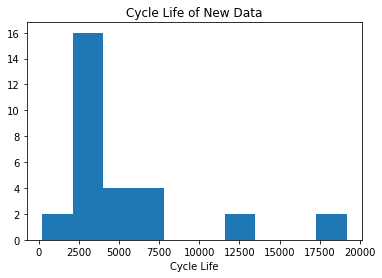

In [27]:
plt.hist(new_df['capacity_0.8'])
plt.xlabel("Cycle Life")
plt.title("Cycle Life of New Data")
plt.show()

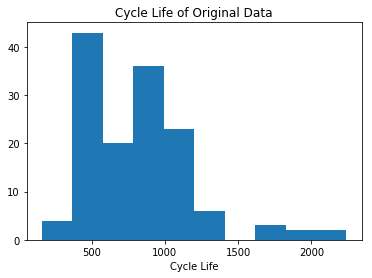

In [28]:
plt.hist(old_df['capacity_0.8'])
plt.xlabel("Cycle Life")
plt.title("Cycle Life of Original Data")
plt.show()

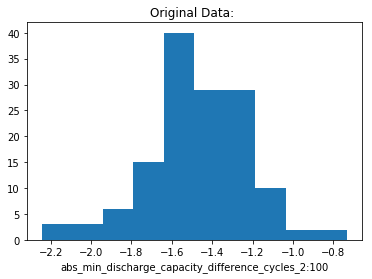

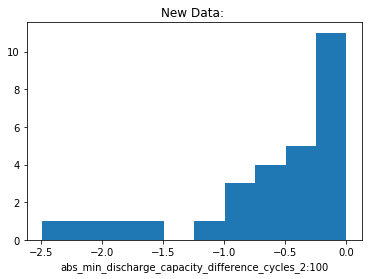

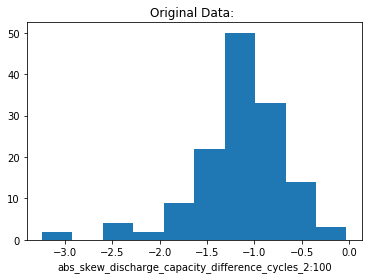

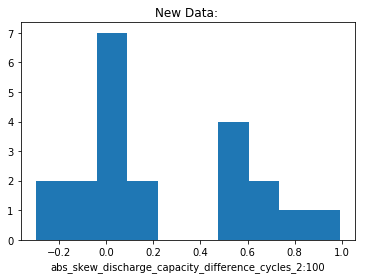

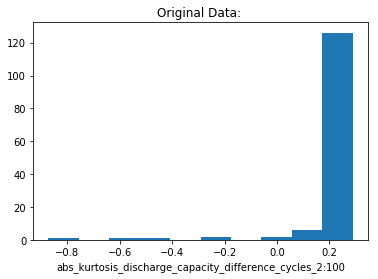

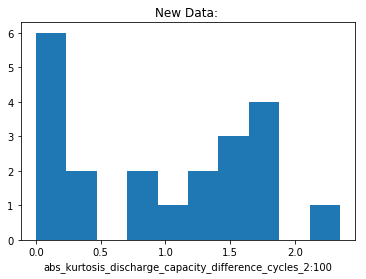

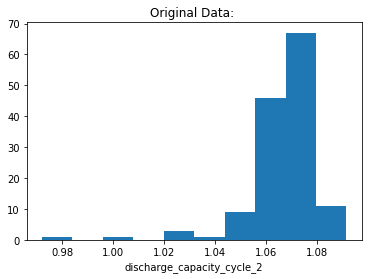

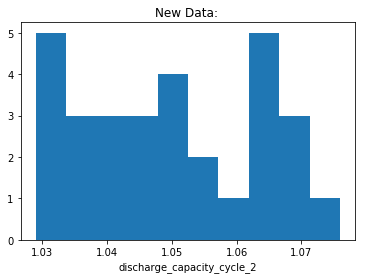

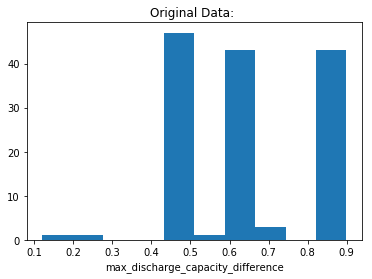

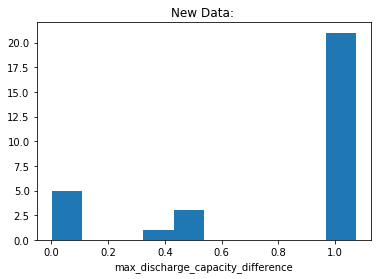

In [38]:
fig = plt.Figure(figsize=(6,50))
i = 1
for feat in discharge_model_features:
    fig.add_subplot(2*len(discharge_model_features), 1, i)
    plt.hist(old_df[feat].replace([-np.inf, np.inf], np.nan).dropna())
    plt.xlabel(feat)
    plt.title("Original Data: ")
    plt.show()
    
    i+=1
    fig.add_subplot(2*len(discharge_model_features), 1, i)
    plt.hist(new_df[feat].replace([-np.inf, np.inf], np.nan).dropna())
    plt.xlabel(feat)
    plt.title("New Data: ")
    plt.show()

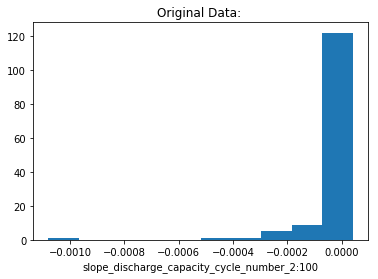

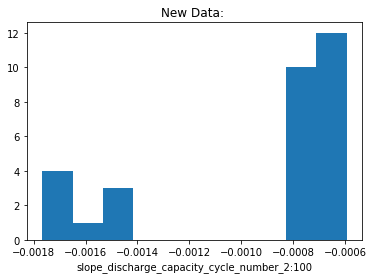

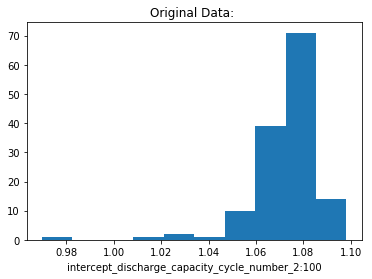

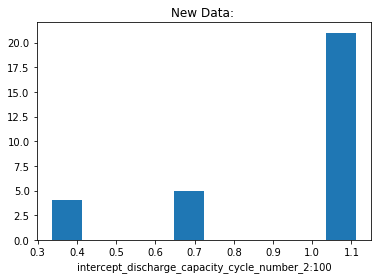

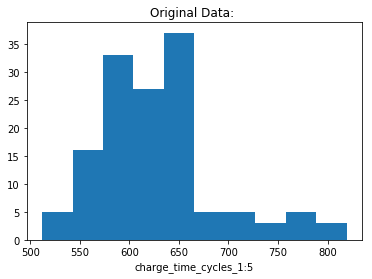

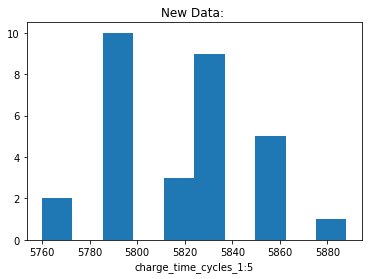

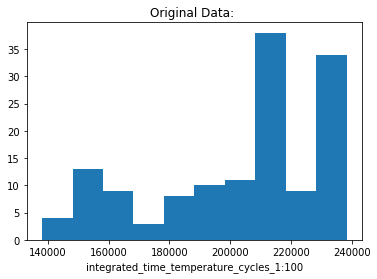

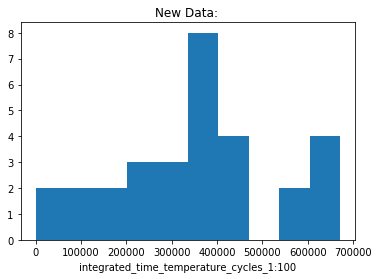

In [39]:
fig = plt.Figure(figsize=(6,50))
i = 1
for feat in full_model_features:
    fig.add_subplot(2*len(discharge_model_features), 1, i)
    plt.hist(old_df[feat].replace([-np.inf, np.inf], np.nan).dropna())
    plt.xlabel(feat)
    plt.title("Original Data: ")
    plt.show()
    
    i+=1
    fig.add_subplot(2*len(discharge_model_features), 1, i)
    plt.hist(new_df[feat].replace([-np.inf, np.inf], np.nan).dropna())
    plt.xlabel(feat)
    plt.title("New Data: ")
    plt.show()

### Transforming Cycle Life

In [42]:
old_df['sqrt_capacity_0.8'] = np.sqrt(old_df['capacity_0.8'])
new_df['sqrt_capacity_0.8'] = np.sqrt(new_df['capacity_0.8'])
old_df['log_capacity_0.8'] = np.log(old_df['capacity_0.8'])
new_df['log_capacity_0.8'] = np.log(new_df['capacity_0.8'])

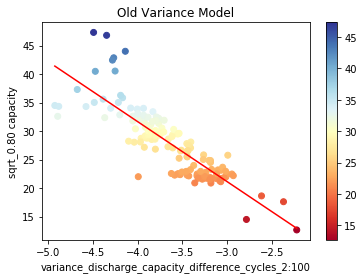

-0.8456942538990686

In [40]:
y = old_df["sqrt_capacity_0.8"]
x = old_df["abs_variance_discharge_capacity_difference_cycles_2:100"]
y2 = y[x.index]
#fig.add_subplot(len(xvars), 1, i + 1)
plt.xlabel("variance_discharge_capacity_difference_cycles_2:100")
plt.ylabel('sqrt_0.80 capacity')
plt.scatter(x, y2, c=y2, cmap="RdYlBu")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
plt.colorbar()
plt.title("Old Variance Model")
plt.show()
old_df.corr().loc["abs_variance_discharge_capacity_difference_cycles_2:100", 'sqrt_capacity_0.8']

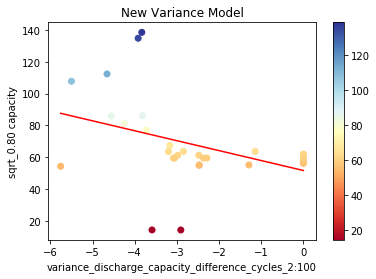

-0.3876401979755035

In [41]:
y = new_df["sqrt_capacity_0.8"]
x = new_df["abs_variance_discharge_capacity_difference_cycles_2:100"]
y2 = y[x.index]
#fig.add_subplot(len(xvars), 1, i + 1)
plt.xlabel("variance_discharge_capacity_difference_cycles_2:100")
plt.ylabel('sqrt_0.80 capacity')
plt.scatter(x, y2, c=y2, cmap="RdYlBu")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
plt.colorbar()
plt.title("New Variance Model")
plt.show()
new_df.corr().loc["abs_variance_discharge_capacity_difference_cycles_2:100", 'sqrt_capacity_0.8']

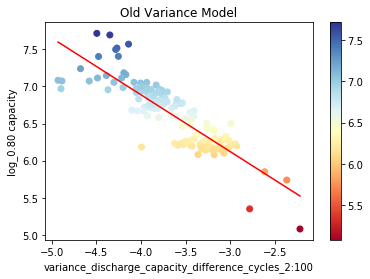

-0.8628016892564124

In [44]:
y = old_df["log_capacity_0.8"]
x = old_df["abs_variance_discharge_capacity_difference_cycles_2:100"]
y2 = y[x.index]
#fig.add_subplot(len(xvars), 1, i + 1)
plt.xlabel("variance_discharge_capacity_difference_cycles_2:100")
plt.ylabel('log_0.80 capacity')
plt.scatter(x, y2, c=y2, cmap="RdYlBu")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
plt.colorbar()
plt.title("Old Variance Model")
plt.show()
old_df.corr().loc["abs_variance_discharge_capacity_difference_cycles_2:100", 'log_capacity_0.8']

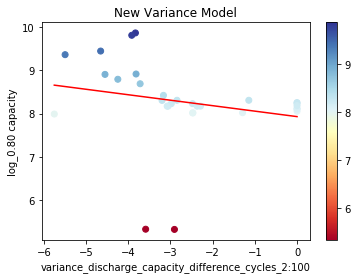

-0.22212096749301474

In [45]:
y = new_df["log_capacity_0.8"]
x = new_df["abs_variance_discharge_capacity_difference_cycles_2:100"]
y2 = y[x.index]
#fig.add_subplot(len(xvars), 1, i + 1)
plt.xlabel("variance_discharge_capacity_difference_cycles_2:100")
plt.ylabel('log_0.80 capacity')
plt.scatter(x, y2, c=y2, cmap="RdYlBu")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), 'r', label="fitted line")
plt.colorbar()
plt.title("New Variance Model")
plt.show()
new_df.corr().loc["abs_variance_discharge_capacity_difference_cycles_2:100", 'log_capacity_0.8']

When applying the log and square root transformations to the Cycle Life, the correlations get stronger for the original data, but the correlations gets weaker for the new data. However, the data looks more normalized. 